# Using A* algorithm and TSP to determine shortest tour around waypoints in a grid

Name:Yogesh Venkatesa Perumal

Roll:106118110

## Imports and Misc. Helper Functions 

In [1]:
from queue import PriorityQueue
from itertools import combinations

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from icecream import ic
import numpy as np
import heapq
import seaborn as sns

In [2]:
# Save the original print function
original_print = print

# Define a global variable to control printing
enable_print = True

# Define a new print function that checks the global variable
def new_print(*args, **kwargs):
    if enable_print:
        original_print(*args, **kwargs)

# Replace the built-in print with the new function
print = new_print

In [3]:
def cyclic_generator(items):
    index = 0  # Start from the first item
    while True:  # Create an infinite loop
        yield items[index]  # Yield the current item
        index = (index + 1) % len(items)  

gen=cyclic_generator(["Greys","Blues","Greens","Oranges","Purples","Reds"])

# using this to make consecutive grid colors different, only for visualisation purpose

## Define the grid, waypoints and obstacles

Each point in a grid can be space(white), a waypoint(black) or an obstacle(grey).

In [4]:
def define_grid(*,length=20):
    area=length*length
    indices = np.random.choice(np.arange(area), size=area//10, replace=False)
    grid = np.zeros((length, length))
    
    
    obstacles_indices,waypoints_indices= indices[:-4],indices[-4:]
    grid.flat[obstacles_indices] = 1
    grid.flat[waypoints_indices] = 2
    

    y, x = divmod(waypoints_indices, length)
    waypoints=[]
    for i,j in zip(x,y):
        waypoints.append((i,j))
    
    y, x = divmod(obstacles_indices, length)
    obstacles=[]
    for i,j in zip(x,y):
        obstacles.append((i,j))
    
    
    return grid, waypoints,obstacles

def display_the_grid_plot(title=None,*,grid,waypoints):
    plt.figure(figsize=(3, 3))
    
    plt.imshow(grid, cmap=next(gen), interpolation='nearest',origin='upper')
    
    if waypoints!=None:
        for x,y in waypoints:
            plt.text(x=x,y=y,s=f"{(x,y)}",fontdict={"color":"red","size":9},
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0'))
        
    if not title:
        plt.title("Grid with Randomised Waypoints(black) and Obstacles(grey)")
    else:
        plt.title(title)
    plt.show()


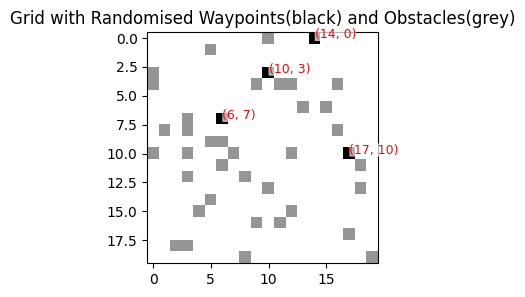

In [5]:
# Generate grid
grid,waypoints,obstacles=define_grid()
display_the_grid_plot(grid=grid,waypoints=waypoints)

In [6]:
def print_coordinates_waypoints_and_obstacles(*,waypoints,obstacles):
    print ("Waypoints are:")
    print(waypoints)
    print("Obstacles are:")
    print(obstacles)
    
print_coordinates_waypoints_and_obstacles(waypoints=waypoints,obstacles=obstacles)

Waypoints are:
[(6, 7), (14, 0), (10, 3), (17, 10)]
Obstacles are:
[(16, 8), (6, 9), (1, 8), (3, 18), (5, 9), (17, 17), (16, 4), (3, 8), (10, 13), (11, 4), (11, 16), (8, 12), (19, 19), (6, 11), (5, 1), (5, 14), (8, 19), (10, 0), (4, 15), (0, 4), (18, 11), (0, 10), (18, 13), (9, 4), (3, 10), (12, 15), (12, 4), (12, 10), (7, 10), (2, 18), (9, 16), (3, 7), (0, 3), (3, 12), (15, 6), (13, 6)]


## Computing the distance matrix

### Using A* algorithm to Compute Shortest Path bw 2 Nodes

We will be iterating through every possible pair of waypoints. For each  pair of waypoints, we will run the A* algorithm to solve 3 things

The a_star function returns a dictionary containing keys 
"shortest_path":int,
"pathway":list,
"steps_taken":int

In [7]:
class Node():
    def __init__(self,parent=None, position=None):
        self.name=f"Node{position}"
        self.parent=parent
        self.position=position # (x,y)
        self.g=0
        self.h=0
        self.f=0

    #def __eq__(self,other):
    #    return self.position==other.position

    def __lt__(self, other):
        return self.f< other.f
    
    def __str__(self):
        return self.name
    

In [8]:
class MaxIterationsExceededError(Exception):
    def __init__(self, message):
        self.message = message
        super().__init__(self.message)

In [9]:

def backtrack_and_find_pathway(*,goal_node):
    pathway=[] #stores list of (x,y) coordinates on how to reach from start to end 
    t=goal_node
    while t.parent!=None:
        pathway.insert(0,t.position)
        t=t.parent
    pathway.insert(0,t.position)
    start_node=t
    print(f"Pathway from {start_node} to {goal_node} is\n{pathway}\n")
    return pathway
    
    
def a_star(*,start, goal, grid):
    MAX_ITERATIONS=9999
    
    #ic(f"using a* to figure shortest distance bw {start} and {goal}")
    start_node = Node(parent=None, position=tuple(start))
    goal_node = Node(parent=None, position=tuple(goal))
    open_list = []
    closed_list = []
    heapq.heappush(open_list, (start_node.f, start_node))

    
    counter=0
    while open_list:
        counter+=1
        
        if counter>MAX_ITERATIONS:
            raise MaxIterationsExceededError("unable to determine shortest distance after 9999 steps")
        current_node = heapq.heappop(open_list)[1] # from the open_list, obtaining the next highest priority (sorted by fscore) 
        #ic(f"next opennode is {current_node.name}")
        if current_node.position == goal_node.position: # implicitly comparing x and y coordinates of both nodes
            return {"shortest_distance":current_node.g,
                    "pathway":backtrack_and_find_pathway(goal_node=current_node),
                    "steps":counter}

        children = []
        for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0)]:
            new_node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])

            #node meeting one of these criteria will fail to be a potential future node to search
            if new_node_position[0] > (len(grid) - 1):
                #ic(f"node {node_position} border at bottom")
                continue
            elif new_node_position[0] < 0:
                #ic(f"node {node_position} border at top")
                continue
            elif new_node_position[1] > (len(grid[0]) - 1):
                #ic(f"node {node_position} border at right")
                continue
            elif new_node_position[1] < 0:
                #ic(f"node {node_position} border at left")
                continue
            
            if grid[new_node_position[1]][new_node_position[0]] == 1: # encountered obstacle
                #ic(f"encountered obstacle at {(new_node_position[0],new_node_position[1])}. fail.")
                continue
                
            # if here, the node has passed all the tests
            new_node = Node(parent=current_node, position=new_node_position)
            children.append(new_node)
        
        
            
        #print("camehere")
        #ic("iterated in all 4 directions")
        for child in children: # intent- final checks before adding child to open_list
            if child in closed_list:
                continue

            child.g = current_node.g + 1 # true distance travelled upto now
            child.h = abs(child.position[0] - goal_node.position[0]) + abs(child.position[1] - goal_node.position[1])
            child.f = child.g + child.h

            if any(child.position == open_node[1].position and child.g > open_node[1].g for open_node in open_list):
                continue
                
            # came here, this child node is perfectly eligible for future exploration
            heapq.heappush(open_list, (child.f, child)) 
            
        
        closed_list.append(current_node)
        #ic(f"closed_list is {closed_list}")
        
        
    return []



### Compute Distance matrix

In [10]:

def compute_distance_matrix(*,waypoints,grid):
    ap={}
    mapper_index_to_position={}
    list_counters=[]
    n_rows,n_cols = len(waypoints),len(waypoints)
    distance_matrix = [[0 for j in range(n_cols)] for i in range(n_rows)]
    
    for i in range(len(waypoints)):
        for j in range(len(waypoints)):
            if i == j:
                continue
            
            start=waypoints[i] #start = (x,y)
            goal=waypoints[j] # end = (x,y)
            
            
            shortest_distance,pathway,steps= a_star(grid=grid,start=start,goal=goal).values()
            
            list_counters.append(steps)
            
            #filling up the distance matrix
            distance_matrix[i][j]=len(pathway)-1
            mapper_index_to_position[(i,j)]=(start,goal)
            ap[(start),(goal)]={"pathway":pathway,"distance":len(pathway)-1,"steps_to_converge":steps}
                                
                
    return distance_matrix,mapper_index_to_position,ap


In [11]:
distance_matrix,mapper_index_to_position,ap=compute_distance_matrix(waypoints=waypoints,grid=grid)
# distance_matrix is storing the shortest paths
# mapper_index_to_position is used to get back (x,y) coordinates using index i (needed after tsp_solve)
# ap is a dict that returns [pathway,distance] on supplying (start,goal)

Pathway from Node(6, 7) to Node(14, 0) is
[(6, 7), (6, 6), (7, 6), (7, 5), (7, 4), (8, 4), (8, 3), (9, 3), (10, 3), (10, 2), (10, 1), (11, 1), (11, 0), (12, 0), (13, 0), (14, 0)]

Pathway from Node(6, 7) to Node(10, 3) is
[(6, 7), (7, 7), (8, 7), (8, 6), (9, 6), (10, 6), (10, 5), (10, 4), (10, 3)]

Pathway from Node(6, 7) to Node(17, 10) is
[(6, 7), (7, 7), (7, 8), (8, 8), (9, 8), (10, 8), (11, 8), (12, 8), (13, 8), (14, 8), (14, 9), (15, 9), (15, 10), (16, 10), (17, 10)]

Pathway from Node(14, 0) to Node(6, 7) is
[(14, 0), (13, 0), (12, 0), (12, 1), (11, 1), (11, 2), (11, 3), (10, 3), (10, 4), (10, 5), (9, 5), (9, 6), (8, 6), (7, 6), (7, 7), (6, 7)]

Pathway from Node(14, 0) to Node(10, 3) is
[(14, 0), (13, 0), (12, 0), (11, 0), (11, 1), (11, 2), (11, 3), (10, 3)]

Pathway from Node(14, 0) to Node(17, 10) is
[(14, 0), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7), (15, 7), (15, 8), (15, 9), (16, 9), (16, 10), (17, 10)]

Pathway from Node(10, 3) to Node(6, 7) is
[(10, 3

In [12]:
pd.DataFrame(distance_matrix)

,0,1,2,3
0,0,15,8,14
1,15,0,7,13
2,8,7,0,14
3,14,13,14,0


In [13]:
#an example ap
literal_first_key=list(ap.keys())[0]
print(ap[literal_first_key])

{'pathway': [(6, 7), (6, 6), (7, 6), (7, 5), (7, 4), (8, 4), (8, 3), (9, 3), (10, 3), (10, 2), (10, 1), (11, 1), (11, 0), (12, 0), (13, 0), (14, 0)], 'distance': 15, 'steps_to_converge': 81}


### Plots for all computed shortest points

In [14]:
for (start,goal),values in ap.items():
    pathway=values["pathway"]
    distance=values["distance"]
    steps=values["steps_to_converge"]
    print(steps)
    break

81


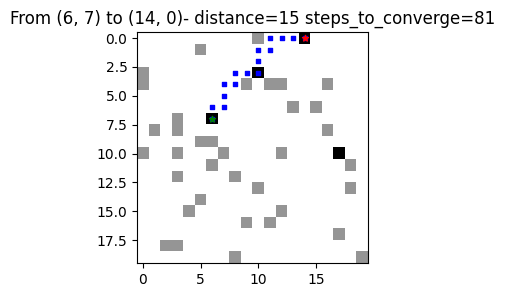

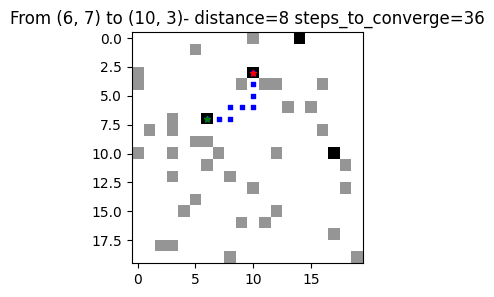

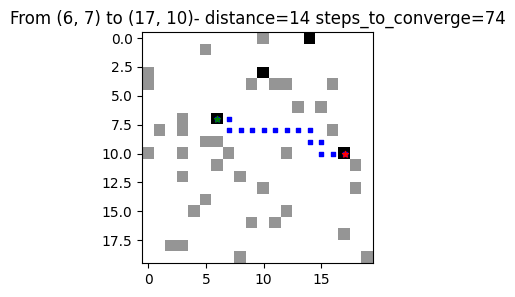

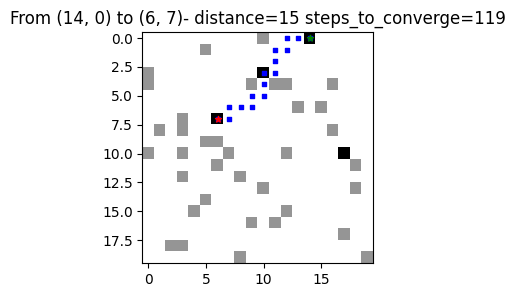

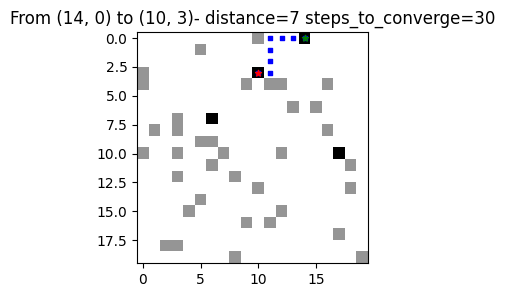

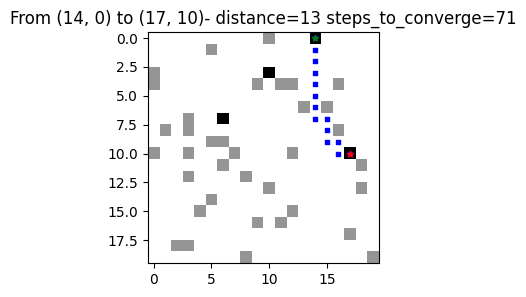

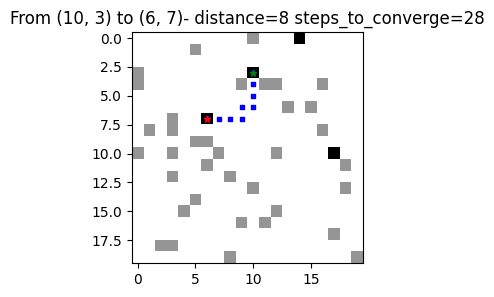

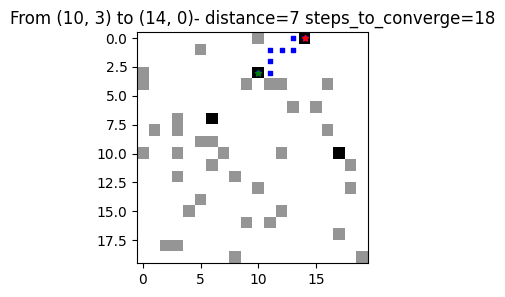

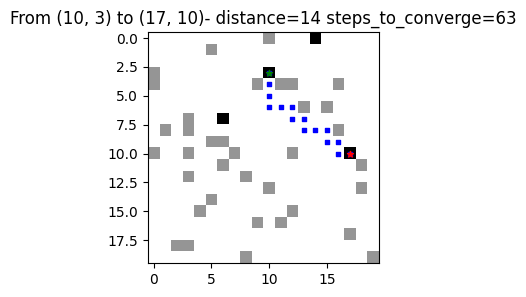

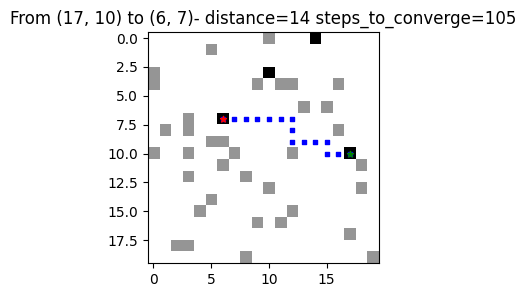

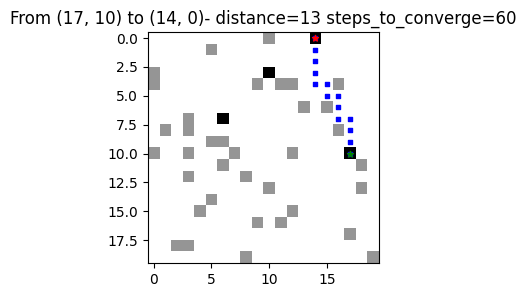

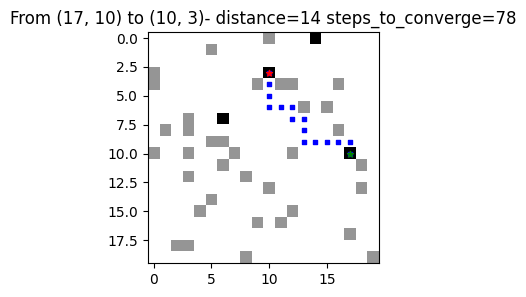

In [15]:
def plot_all_a_star_plots():
    for (start,goal),values in ap.items():
        pathway=values["pathway"]
        distance=values["distance"]
        steps=values["steps_to_converge"]

        fig, ax = plt.subplots(figsize=(3, 3))
        ax.imshow(grid, cmap='Greys', origin='upper')

        # Mark the path
        for step in pathway:
            ax.scatter(step[0], step[1], marker='s', color='blue', s=10)

        # Mark the start and goal positions
        ax.scatter(start[0], start[1], marker='*', color='green', s=20)
        ax.scatter(goal[0], goal[1], marker='*', color='red', s=20)
        ax.set_title(f"From {start} to {goal}- distance={distance} steps_to_converge={steps}")
        plt.show()
plot_all_a_star_plots()

## Travelling Salesman Solver

In [16]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def solve_tsp(distance_matrix):
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        # Convert routing variable indices to distance matrix indices.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        # Retrieve the distance, handling infinity properly.
        distance = distance_matrix[from_node][to_node]
        if np.isinf(distance):
            return routing_model.registered_penalty()  # Large penalty for infeasible paths
        return int(distance)  # Convert float to int if necessar
        
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.Solve()
    if solution:
        index = routing.Start(0)
        plan_output = [] #'Route:\n'
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output.append(manager.IndexToNode(index)) #+= f' {manager.IndexToNode(index)} ->'
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
        plan_output.append(manager.IndexToNode(index)) #+= f'{manager.IndexToNode(index)}\n'
    return plan_output,route_distance

plan_output,route_distance=solve_tsp(distance_matrix=distance_matrix)
print(plan_output)
print(route_distance)

[0, 2, 1, 3, 0]
42


In [17]:

def interpret_tsp_solver_result(*,distance_matrix,plan_output,route_distance):
    print("For the previously computed distance matrix that is")
    display(pd.DataFrame(distance_matrix))
    plan_output,route_distance=solve_tsp(distance_matrix=distance_matrix)

    print(f"Result of TSP Solver was{plan_output}\n")

    plan_output_mapped=[] 
    for i in range(len(plan_output)-1):
        index_now=plan_output[i]
        index_next=plan_output[i+1]

        plan_output_mapped.append(mapper_index_to_position[index_now,index_next])
    print(f"Therefore proposed route is {plan_output_mapped}")

    print(f'Total Route distance: {route_distance}')

interpret_tsp_solver_result(distance_matrix=distance_matrix,plan_output=plan_output,route_distance=route_distance)

For the previously computed distance matrix that is


,0,1,2,3
0,0,15,8,14
1,15,0,7,13
2,8,7,0,14
3,14,13,14,0


Result of TSP Solver was[0, 2, 1, 3, 0]

Therefore proposed route is [((6, 7), (10, 3)), ((10, 3), (14, 0)), ((14, 0), (17, 10)), ((17, 10), (6, 7))]
Total Route distance: 42


## Final Route as determined by A* + TSP

The final optimised route is as follow

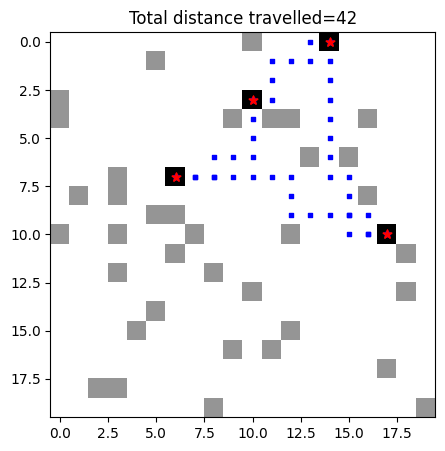

In [18]:
def  display_final_diagram():
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(grid, cmap='Greys', origin='upper')

    for i in range(len(plan_output)-1):
        index_now=plan_output[i]
        index_next=plan_output[i+1]

        start,goal=mapper_index_to_position[(index_now,index_next)]
        pathway=ap[(start,goal)]['pathway']
        distance=ap[(start,goal)]['distance']
        steps=ap[(start,goal)]['steps_to_converge']
        
    
        # Mark the path
        for (step_x,step_y) in pathway:
            ax.scatter(step_x, step_y, marker='s', color='blue', s=10)

        #marking the start and goal positions
        ax.scatter(start[0], start[1], marker='*', color='red', s=40)
        ax.scatter(goal[0], goal[1], marker='*', color='red', s=40)
    ax.set_title(f"Total distance travelled={route_distance}")
    plt.show()
    
display_final_diagram()

## Dataframe that summarises computations done so far

In [19]:
def retrieve_df(*,ap):
    df=pd.DataFrame(ap).T
    
    df = df.astype({'distance': int, 'steps_to_converge': int})
    
    return df [["distance","steps_to_converge"]]
def display_df(*,df):
    display(df)
    df.describe()

def retrieve_summary(*,df):
    return df.describe()


In [20]:
df=retrieve_df(ap=ap)
display_df(df=df)

distance  steps_to_converge
(6, 7)   (14, 0)         15                 81
         (10, 3)          8                 36
         (17, 10)        14                 74
(14, 0)  (6, 7)          15                119
         (10, 3)          7                 30
         (17, 10)        13                 71
(10, 3)  (6, 7)           8                 28
         (14, 0)          7                 18
         (17, 10)        14                 63
(17, 10) (6, 7)          14                105
         (14, 0)         13                 60
         (10, 3)         14                 78

## Running one simulation (from start to finish)

In [21]:
df_summaries=[]
def run_one_simulation(title=None):
    
    global enable_print
    #del grid,waypoints,obstacles
    grid,waypoints,obstacles=define_grid()
    
    enable_print=False
    distance_matrix,mapper_index_to_position,ap=compute_distance_matrix(waypoints=waypoints,grid=grid)
    display_the_grid_plot(title=title,grid=grid,waypoints=waypoints)
    
    
    #plot_all_a_star_plots()
    
    plan_output,route_distance=solve_tsp(distance_matrix=distance_matrix)
    interpret_tsp_solver_result(distance_matrix=distance_matrix,plan_output=plan_output,route_distance=route_distance)
    enable_print=True
    #display_final_diagram()
    df=retrieve_df(ap=ap)
    display_df(df=df)
    
    return df    
    

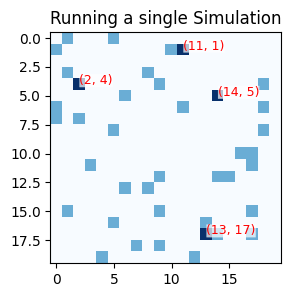

,0,1,2,3
0,0,7,13,15
1,7,0,12,18
2,13,12,0,24
3,15,18,24,0


distance  steps_to_converge
(14, 5)  (11, 1)          7                 27
         (2, 4)          13                 35
         (13, 17)        15                177
(11, 1)  (14, 5)          7                 28
         (2, 4)          12                 37
         (13, 17)        18                224
(2, 4)   (14, 5)         13                 31
         (11, 1)         12                 66
         (13, 17)        24                304
(13, 17) (14, 5)         15                 51
         (11, 1)         18                 83
         (2, 4)          24                302

distance  steps_to_converge
(14, 5)  (11, 1)          7                 27
         (2, 4)          13                 35
         (13, 17)        15                177
(11, 1)  (14, 5)          7                 28
         (2, 4)          12                 37
         (13, 17)        18                224
(2, 4)   (14, 5)         13                 31
         (11, 1)         12                 66
         (13, 17)        24                304
(13, 17) (14, 5)         15                 51
         (11, 1)         18                 83
         (2, 4)          24                302

In [22]:
run_one_simulation(title="Running a single Simulation")


## Running multiple simulations and determining convergence stats  

In [23]:
#INPUTS TO THE SIMULATION- USER CAN ALTER

n_simulations=10 # represents the number of times to run the experiment 
length=20 # density of grid, for example length=20 means create 20x20 grid

SIMULATION 0


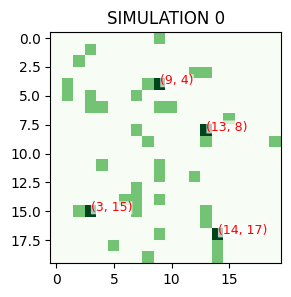

,0,1,2,3
0,0,17,18,8
1,17,0,13,17
2,18,13,0,10
3,8,17,10,0


distance  steps_to_converge
(9, 4)   (3, 15)         17                 70
         (14, 17)        18                 71
         (13, 8)          8                 26
(3, 15)  (9, 4)          17                189
         (14, 17)        13                 69
         (13, 8)         17                102
(14, 17) (9, 4)          18                169
         (3, 15)         13                 66
         (13, 8)         10                 24
(13, 8)  (9, 4)           8                 34
         (3, 15)         17                140
         (14, 17)        10                 11

SIMULATION 1


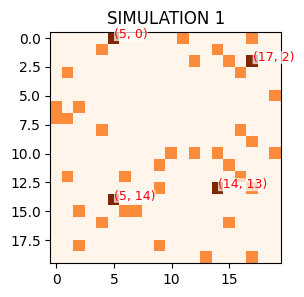

,0,1,2,3
0,0,16,22,14
1,16,0,16,24
2,22,16,0,10
3,14,24,10,0


distance  steps_to_converge
(5, 0)   (17, 2)         16                532
         (14, 13)        22                163
         (5, 14)         14                 15
(17, 2)  (5, 0)          16                111
         (14, 13)        16                242
         (5, 14)         24                276
(14, 13) (5, 0)          22                138
         (17, 2)         16                 88
         (5, 14)         10                 24
(5, 14)  (5, 0)          14                 15
         (17, 2)         24                332
         (14, 13)        10                 25

SIMULATION 2


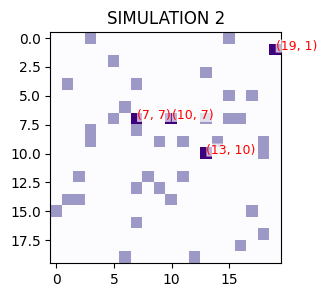

,0,1,2,3
0,0,3,18,9
1,3,0,15,6
2,18,15,0,15
3,9,6,15,0


distance  steps_to_converge
(7, 7)   (10, 7)          3                  4
         (19, 1)         18                157
         (13, 10)         9                 33
(10, 7)  (7, 7)           3                  4
         (19, 1)         15                 93
         (13, 10)         6                 14
(19, 1)  (7, 7)          18                130
         (10, 7)         15                 64
         (13, 10)        15                 65
(13, 10) (7, 7)           9                 33
         (10, 7)          6                 24
         (19, 1)         15                 83

SIMULATION 3


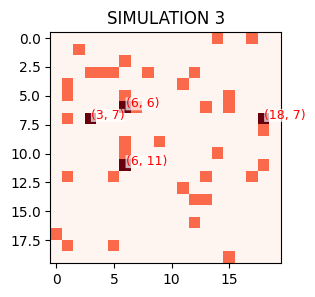

,0,1,2,3
0,0,4,15,7
1,4,0,13,7
2,15,13,0,16
3,7,7,16,0


distance  steps_to_converge
(3, 7)  (6, 6)          4                  9
        (18, 7)        15                 16
        (6, 11)         7                 19
(6, 6)  (3, 7)          4                 11
        (18, 7)        13                 14
        (6, 11)         7                 31
(18, 7) (3, 7)         15                 16
        (6, 6)         13                 34
        (6, 11)        16                 70
(6, 11) (3, 7)          7                 24
        (6, 6)          7                 21
        (18, 7)        16                 91

SIMULATION 4


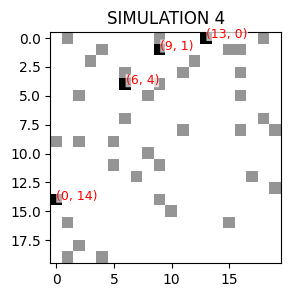

,0,1,2,3
0,0,27,11,5
1,27,0,16,22
2,11,16,0,6
3,5,22,6,0


distance  steps_to_converge
(13, 0) (0, 14)        27                369
        (6, 4)         11                 45
        (9, 1)          5                 13
(0, 14) (13, 0)        27                287
        (6, 4)         16                165
        (9, 1)         22                194
(6, 4)  (13, 0)        11                 37
        (0, 14)        16                 86
        (9, 1)          6                 16
(9, 1)  (13, 0)         5                  9
        (0, 14)        22                215
        (6, 4)          6                 20

SIMULATION 5


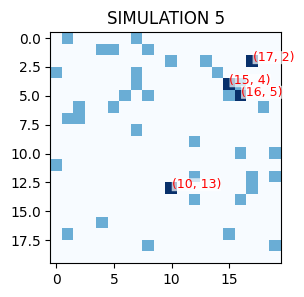

,0,1,2,3
0,0,4,14,6
1,4,0,18,4
2,14,18,0,14
3,6,4,14,0


distance  steps_to_converge
(16, 5)  (17, 2)          4                  5
         (10, 13)        14                124
         (15, 4)          6                 54
(17, 2)  (16, 5)          4                  8
         (10, 13)        18                134
         (15, 4)          4                 10
(10, 13) (16, 5)         14                 71
         (17, 2)         18                147
         (15, 4)         14                130
(15, 4)  (16, 5)          6                 41
         (17, 2)          4                  7
         (10, 13)        14                 78

SIMULATION 6


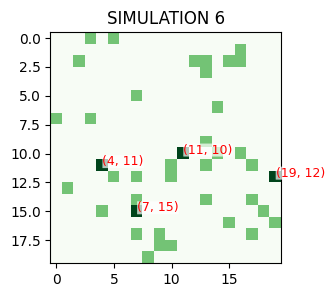

,0,1,2,3
0,0,10,9,8
1,10,0,15,18
2,9,15,0,7
3,8,18,7,0


distance  steps_to_converge
(11, 10) (19, 12)        10                 25
         (7, 15)          9                 27
         (4, 11)          8                 20
(19, 12) (11, 10)        10                 32
         (7, 15)         15                 66
         (4, 11)         18                188
(7, 15)  (11, 10)         9                 29
         (19, 12)        15                 62
         (4, 11)          7                 22
(4, 11)  (11, 10)         8                 25
         (19, 12)        18                175
         (7, 15)          7                 17

SIMULATION 7


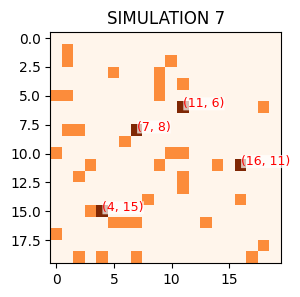

,0,1,2,3
0,0,10,16,16
1,10,0,12,6
2,16,12,0,10
3,16,6,10,0


distance  steps_to_converge
(4, 15)  (7, 8)          10                 72
         (16, 11)        16                579
         (11, 6)         16                 75
(7, 8)   (4, 15)         10                 59
         (16, 11)        12                 51
         (11, 6)          6                 20
(16, 11) (4, 15)         16                137
         (7, 8)          12                 67
         (11, 6)         10                 60
(11, 6)  (4, 15)         16                150
         (7, 8)           6                 15
         (16, 11)        10                 33

SIMULATION 8


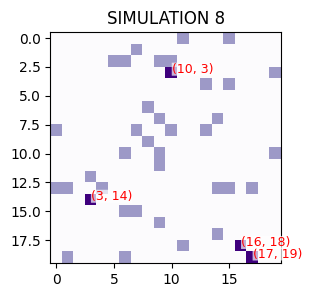

,0,1,2,3
0,0,19,17,18
1,19,0,2,23
2,17,2,0,21
3,18,23,21,0


distance  steps_to_converge
(3, 14)  (17, 19)        19                120
         (16, 18)        17                141
         (10, 3)         18                161
(17, 19) (3, 14)         19                149
         (16, 18)         2                  4
         (10, 3)         23                288
(16, 18) (3, 14)         17                 57
         (17, 19)         2                  4
         (10, 3)         21                256
(10, 3)  (3, 14)         18                158
         (17, 19)        23                177
         (16, 18)        21                130

SIMULATION 9


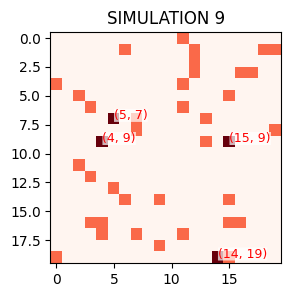

,0,1,2,3
0,0,13,20,3
1,13,0,11,14
2,20,11,0,21
3,3,14,21,0


distance  steps_to_converge
(4, 9)   (15, 9)         13                 54
         (14, 19)        20                166
         (5, 7)           3                  7
(15, 9)  (4, 9)          13                 56
         (14, 19)        11                 28
         (5, 7)          14                105
(14, 19) (4, 9)          20                148
         (15, 9)         11                 22
         (5, 7)          21                155
(5, 7)   (4, 9)           3                  7
         (15, 9)         14                 83
         (14, 19)        21                293

RESULTS FROM 10 SIMULATIONS


,distance,steps_to_converge
0,17,70
1,18,71
2,8,26
3,17,189
4,13,69
...,...,...
115,11,22
116,21,155
117,3,7
118,14,83


SIMULATION0                   SIMULATION1                   SIMULATION2  \
         distance steps_to_converge    distance steps_to_converge    distance   
count   12.000000         12.000000   12.000000         12.000000   12.000000   
mean    13.833333         80.916667   17.000000        163.416667   11.000000   
std      3.973396         58.233790    4.935953        158.072744    5.624621   
min      8.000000         11.000000   10.000000         15.000000    3.000000   
25%     10.000000         32.000000   14.000000         24.750000    6.000000   
50%     15.000000         69.500000   16.000000        124.500000   12.000000   
75%     17.000000        111.500000   22.000000        250.500000   15.000000   
max     18.000000        189.000000   24.000000        532.000000   18.000000   

                        SIMULATION3                   SIMULATION4  \
      steps_to_converge    distance steps_to_converge    distance   
count         12.000000   12.000000         12.000000   12.000000   
mean          58.666667   10.333333         29.666667   14.500000   
std           49.624652    4.735424         25.270656    8.415354   
min            4.000000    4.000000          9.000000    5.000000   
25%           21.500000    7.000000         15.500000    6.000000   
50%           48.500000   10.000000         20.000000   13.500000   
75%           85.500000   15.000000         31.750000   22.000000   
max          157.000000   16.000000         91.000000   27.000000   

                        SIMULATION5                   SIMULATION6  \
      steps_to_converge    distance steps_to_converge    distance   
count         12.000000    12.00000         12.000000   12.000000   
mean         121.333333    10.00000         67.416667   11.166667   
std          122.344769     5.78399         54.988360    4.152400   
min            9.000000     4.00000          5.000000    7.000000   
25%           19.000000     4.00000          9.500000    8.000000   
50%           65.500000    10.00000         62.500000    9.500000   
75%          199.250000    14.00000        125.500000   15.000000   
max          369.000000    18.00000        147.000000   18.000000   

                        SIMULATION7                   SIMULATION8  \
      steps_to_converge    distance steps_to_converge    distance   
count         12.000000   12.000000         12.000000   12.000000   
mean          57.333333   11.666667        109.833333   16.666667   
std           60.106471    3.700942        153.280393    7.152029   
min           17.000000    6.000000         15.000000    2.000000   
25%           24.250000   10.000000         46.500000   17.000000   
50%           28.000000   11.000000         63.500000   18.500000   
75%           63.000000   16.000000         90.500000   21.000000   
max          188.000000   16.000000        579.000000   23.000000   

                        SIMULATION9                    
      steps_to_converge    distance steps_to_converge  
count         12.000000   12.000000         12.000000  
mean         137.083333   13.666667         93.666667  
std           86.263295    6.257117         84.951680  
min            4.000000    3.000000          7.000000  
25%          104.250000   11.000000         26.500000  
50%          145.000000   13.500000         69.500000  
75%          165.000000   20.000000        149.750000  
max          288.000000   21.000000        293.000000

In [24]:
def run_multiple_simulations(n=8):
    dfs=[]
    summarised_dfs=[]
    while len(dfs)<(n):
        try:
            title=f"SIMULATION {len(dfs)}"
            print(title)
            df=run_one_simulation(title=title)
        except MaxIterationsExceededError as e:
            print(f"Crossed allowed max iterations, so redoing simulations")
            continue
            # if it comes here means, then A* algorithm is unable to converge within 9999 steps 
        
        dfs.append(df)
        summarised_dfs.append(df.describe())
    
    combined_dfs= pd.concat(dfs,axis=0,ignore_index=True)
    
    keys=[f"SIMULATION{i}" for i in range(n)]
    summarised_dfs= pd.concat(summarised_dfs,axis=1,keys=keys)
    
    print(f"RESULTS FROM {n} SIMULATIONS")
    display(combined_dfs)
    display(summarised_dfs)
    return combined_dfs,summarised_dfs
    

combined_dfs,summarised_dfs=run_multiple_simulations(n_simulations)


## Convergence Graph

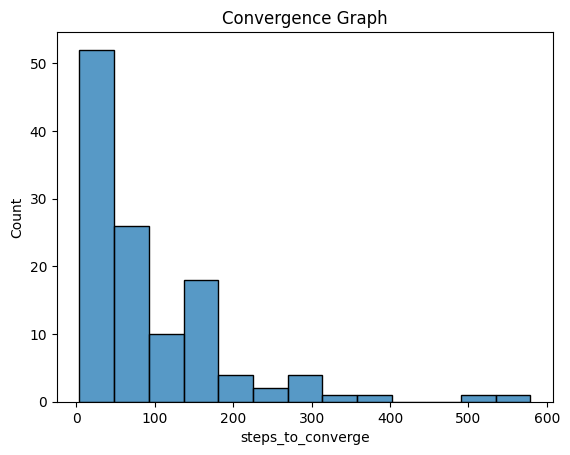

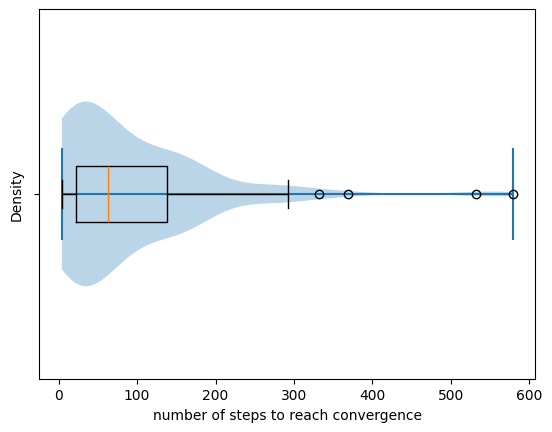

count    120.000000
mean      91.933333
std       99.852137
min        4.000000
25%       22.000000
50%       63.000000
75%      138.500000
max      579.000000
Name: steps_to_converge, dtype: float64

Therefore, For a 20x20 grid, the typical expected steps for A* to converge is around 63.00 units.


In [25]:
sns.histplot(combined_dfs["steps_to_converge"])
plt.title("Convergence Graph")
plt.show()

plt.violinplot([combined_dfs["steps_to_converge"]],vert=False)
plt.boxplot([combined_dfs["steps_to_converge"]],labels=[""],vert=False)
plt.ylabel("Density")
plt.xlabel("number of steps to reach convergence")
plt.show()

display(combined_dfs["steps_to_converge"].describe())
print (f"Therefore, For a {length}x{length} grid, the typical expected steps for A* to converge is around {combined_dfs['steps_to_converge'].median():.2f} units.")

### Conclusion (convergence graph)

In [26]:
print (f"For {length}x{length} grids,") 
print(f"- The A* algorithm takes around {combined_dfs['steps_to_converge'].median():.1f} steps to converge and determine shortest path bw 2 waypoints.") 

For 20x20 grids,
- The A* algorithm takes around 63.0 steps to converge and determine shortest path bw 2 waypoints.
